In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import random

np.random.seed(0) 
random.seed(0)


In [2]:
import yaml
import shutil
import json
import numpy as np
from pathlib import Path

try:
    import torch
    from ultralytics import YOLO
    torch_available = True
except ImportError:
    torch_available = False

try:
    from PIL import Image
    pil_available = True
except ImportError:
    pil_available = False

class SurgicalHandsIntegrator:
    def __init__(self, hands_dataset_path):
        self.hands_dataset_path = Path(hands_dataset_path)
        self.images_dir = self.hands_dataset_path / "images"
        self.annotations_file = self.hands_dataset_path / "annotations.json"

    def load_hand_annotations(self):
        try:
            with open(self.annotations_file, 'r', encoding='utf-8') as f:
                annotations = json.load(f)
            print(f"Anotações carregadas: {len(annotations)} items")
            return annotations
        except Exception as e:
            print(f"Erro ao carregar anotações: {e}")
            return None

    def validate_polygon(self, polygon):
        """Valida se o polígono tem formato correto para segmentação YOLO"""
        if not isinstance(polygon, list):
            return False
        if len(polygon) < 6:  # Mínimo 3 pontos (6 coordenadas)
            return False
        if len(polygon) % 2 != 0:  # Deve ter número par de coordenadas
            return False
        
        # Verificar se todas as coordenadas estão entre 0 e 1
        for coord in polygon:
            if not isinstance(coord, (int, float)):
                return False
            if coord < 0.0 or coord > 1.0:
                return False
        
        return True

    def convert_bbox_to_yolo_polygon(self, bbox, image_width, image_height):
        """Converte bounding box para formato de polígono YOLO normalizado"""
        x, y, w, h = bbox
        
        # Criar polígono retangular a partir da bounding box
        x1, y1 = x, y
        x2, y2 = x + w, y
        x3, y3 = x + w, y + h
        x4, y4 = x, y + h
        
        # Normalizar coordenadas (0-1)
        polygon = [
            x1 / image_width, y1 / image_height,
            x2 / image_width, y2 / image_height,
            x3 / image_width, y3 / image_height,
            x4 / image_width, y4 / image_height
        ]
        
        # Garantir que todas as coordenadas estão entre 0 e 1
        polygon = [max(0.0, min(1.0, coord)) for coord in polygon]
        
        return polygon

    def find_image_file(self, filename):
        possible_paths = [
            self.images_dir / filename,
            self.hands_dataset_path / filename,
            self.hands_dataset_path / "images" / filename
        ]
        
        if self.images_dir.exists():
            for subfolder in self.images_dir.glob("*"):
                if subfolder.is_dir():
                    possible_paths.append(subfolder / filename)
        
        for path in possible_paths:
            if path.exists():
                return path
        
        return None

    def process_coco_format(self, annotations, output_dir):
        """Processa anotações no formato COCO para segmentação YOLO"""
        output_dir = Path(output_dir)
        (output_dir / "images").mkdir(parents=True, exist_ok=True)
        (output_dir / "labels").mkdir(parents=True, exist_ok=True)
        
        images_data = annotations['images']
        annotations_data = annotations['annotations']
        categories = annotations.get('categories', [])
        
        # Mapeamento de categorias
        category_mapping = {}
        for cat in categories:
            cat_id = cat['id']
            cat_name = cat['name'].lower()
            if 'hand' in cat_name or 'mão' in cat_name:
                if 'left' in cat_name or 'esquerda' in cat_name:
                    category_mapping[cat_id] = 0
                elif 'right' in cat_name or 'direita' in cat_name:
                    category_mapping[cat_id] = 1
                else:
                    category_mapping[cat_id] = 0
        
        annotations_by_image = {}
        for ann in annotations_data:
            img_id = ann['image_id']
            if img_id not in annotations_by_image:
                annotations_by_image[img_id] = []
            annotations_by_image[img_id].append(ann)
        
        processed_count = 0
        
        for img_data in images_data:
            img_id = img_data['id']
            img_filename = img_data['file_name']
            img_width = img_data['width']
            img_height = img_data['height']
            
            if img_id not in annotations_by_image:
                continue
            
            img_annotations = annotations_by_image[img_id]
            hand_annotations = []
            for ann in img_annotations:
                cat_id = ann['category_id']
                if cat_id in category_mapping:
                    hand_annotations.append(ann)
            
            if not hand_annotations:
                continue
            
            img_path = self.find_image_file(img_filename)
            if not img_path:
                print(f"Imagem não encontrada: {img_filename}")
                continue
            
            valid_annotations = []
            for ann in hand_annotations:
                class_id = category_mapping[ann['category_id']]
                
                # Processar segmentação
                if 'segmentation' in ann and ann['segmentation'] and len(ann['segmentation']) > 0:
                    segmentation = ann['segmentation'][0]
                    if len(segmentation) >= 6:
                        normalized_seg = []
                        for i in range(0, len(segmentation), 2):
                            if i + 1 < len(segmentation):
                                x_norm = max(0.0, min(1.0, segmentation[i] / img_width))
                                y_norm = max(0.0, min(1.0, segmentation[i + 1] / img_height))
                                normalized_seg.extend([x_norm, y_norm])
                        
                        if self.validate_polygon(normalized_seg):
                            valid_annotations.append([class_id] + normalized_seg)
                
                elif 'bbox' in ann and len(ann['bbox']) >= 4:
                    bbox = ann['bbox']
                    polygon = self.convert_bbox_to_yolo_polygon(bbox, img_width, img_height)
                    if self.validate_polygon(polygon):
                        valid_annotations.append([class_id] + polygon)
            
            # Só processar se houver anotações válidas
            if valid_annotations:
                new_img_name = f"hand_{processed_count:06d}.jpg"
                
                try:
                    if pil_available and img_path.suffix.lower() != '.jpg':
                        pil_image = Image.open(img_path).convert('RGB')
                        pil_image.save(output_dir / "images" / new_img_name, 'JPEG')
                    else:
                        shutil.copy(img_path, output_dir / "images" / new_img_name)
                except Exception as e:
                    print(f"Erro ao processar imagem {img_filename}: {e}")
                    continue
                
                # Salvar anotações válidas
                label_file = output_dir / "labels" / f"hand_{processed_count:06d}.txt"
                with open(label_file, 'w') as f:
                    for detection in valid_annotations:
                        line = f"{detection[0]} " + " ".join(f"{coord:.6f}" for coord in detection[1:])
                        f.write(line + '\n')
                
                processed_count += 1
        
        print(f"Processadas {processed_count} imagens com segmentação de mãos (formato COCO)")
        return processed_count

    def process_sequence_format(self, annotations, output_dir):
        """Processa formato de sequência para segmentação YOLO"""
        output_dir = Path(output_dir)
        (output_dir / "images").mkdir(parents=True, exist_ok=True)
        (output_dir / "labels").mkdir(parents=True, exist_ok=True)
        
        processed_count = 0
        
        if isinstance(annotations, dict):
            for img_name, img_annotations in annotations.items():
                if not isinstance(img_annotations, (list, dict)):
                    continue
                    
                img_path = self.find_image_file(img_name)
                if not img_path:
                    continue
                
                if pil_available:
                    try:
                        with Image.open(img_path) as pil_image:
                            img_width, img_height = pil_image.size
                    except:
                        img_width, img_height = 640, 480
                else:
                    img_width, img_height = 640, 480
                
                valid_annotations = []
                annotations_list = img_annotations if isinstance(img_annotations, list) else [img_annotations]
                
                for ann in annotations_list:
                    if not isinstance(ann, dict):
                        continue
                        
                    class_id = 0
                    if 'class' in ann:
                        class_name = str(ann['class']).lower()
                        if 'right' in class_name or 'direita' in class_name:
                            class_id = 1
                    elif 'category' in ann:
                        class_name = str(ann['category']).lower()
                        if 'right' in class_name or 'direita' in class_name:
                            class_id = 1
                    
                    if 'polygon' in ann or 'segmentation' in ann:
                        coords = ann.get('polygon', ann.get('segmentation', []))
                        if isinstance(coords, list) and len(coords) >= 6:
                            normalized_coords = []
                            for i in range(0, len(coords), 2):
                                if i + 1 < len(coords):
                                    x_norm = max(0.0, min(1.0, coords[i] / img_width))
                                    y_norm = max(0.0, min(1.0, coords[i + 1] / img_height))
                                    normalized_coords.extend([x_norm, y_norm])
                            
                            if self.validate_polygon(normalized_coords):
                                valid_annotations.append([class_id] + normalized_coords)
                    
                    elif 'bbox' in ann and len(ann['bbox']) >= 4:
                        bbox = ann['bbox']
                        polygon = self.convert_bbox_to_yolo_polygon(bbox, img_width, img_height)
                        if self.validate_polygon(polygon):
                            valid_annotations.append([class_id] + polygon)
                
                if valid_annotations:
                    new_img_name = f"hand_{processed_count:06d}.jpg"
                    
                    try:
                        if pil_available and img_path.suffix.lower() != '.jpg':
                            pil_image = Image.open(img_path).convert('RGB')
                            pil_image.save(output_dir / "images" / new_img_name, 'JPEG')
                        else:
                            shutil.copy(img_path, output_dir / "images" / new_img_name)
                    except Exception as e:
                        print(f"Erro ao processar imagem {img_name}: {e}")
                        continue
                    
                    label_file = output_dir / "labels" / f"hand_{processed_count:06d}.txt"
                    with open(label_file, 'w') as f:
                        for detection in valid_annotations:
                            line = f"{detection[0]} " + " ".join(f"{coord:.6f}" for coord in detection[1:])
                            f.write(line + '\n')
                    
                    processed_count += 1
        
        print(f"Processadas {processed_count} imagens no formato de sequência")
        return processed_count

    def process_hands_dataset(self, output_dir):
        """Processa o dataset de mãos para formato de segmentação YOLO"""
        output_dir = Path(output_dir)
        (output_dir / "images").mkdir(parents=True, exist_ok=True)
        (output_dir / "labels").mkdir(parents=True, exist_ok=True)
        
        all_annotations = self.load_hand_annotations()
        if not all_annotations:
            print("Não foi possível carregar anotações")
            return 0
        
        if isinstance(all_annotations, dict) and 'images' in all_annotations and 'annotations' in all_annotations:
            return self.process_coco_format(all_annotations, output_dir)
        else:
            return self.process_sequence_format(all_annotations, output_dir)

class AdvancedYOLOTrainer:
    def __init__(self, base_model="yolo11n-seg.pt"):
        self.base_model = base_model
        if torch_available:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = "cpu"
        
    def validate_and_clean_labels(self, labels_dir):
        """Valida e limpa arquivos de anotação"""
        labels_path = Path(labels_dir)
        cleaned_count = 0
        removed_count = 0
        
        for label_file in labels_path.glob("*.txt"):
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                
                valid_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 9:  # class_id + pelo menos 8 coordenadas (4 pontos)
                        try:
                            class_id = int(parts[0])
                            coords = [float(x) for x in parts[1:]]
                            
                            # Validar coordenadas
                            if len(coords) >= 6 and len(coords) % 2 == 0:
                                # Verificar se estão entre 0 e 1
                                if all(0.0 <= coord <= 1.0 for coord in coords):
                                    valid_lines.append(line.strip())
                        except ValueError:
                            continue
                
                if valid_lines:
                    # Reescrever arquivo com linhas válidas
                    with open(label_file, 'w') as f:
                        for line in valid_lines:
                            f.write(line + '\n')
                    cleaned_count += 1
                else:
                    # Remover arquivo vazio ou inválido
                    label_file.unlink()
                    # Remover imagem correspondente
                    img_file = labels_path.parent / "images" / f"{label_file.stem}.jpg"
                    if img_file.exists():
                        img_file.unlink()
                    removed_count += 1
                    
            except Exception as e:
                print(f"Erro ao processar {label_file}: {e}")
                label_file.unlink()
                removed_count += 1
        
        print(f"Labels validados: {cleaned_count} limpos, {removed_count} removidos")
        return cleaned_count

    def prepare_combined_dataset(self, surgical_data_path, hands_dataset_path):
        combined_dir = Path("combined_surgical_dataset")
        
        # Limpar diretório anterior se existir
        if combined_dir.exists():
            shutil.rmtree(combined_dir)
        
        (combined_dir / "images/train").mkdir(parents=True, exist_ok=True)
        (combined_dir / "labels/train").mkdir(parents=True, exist_ok=True)
        
        surgical_path = Path(surgical_data_path)
        instrument_count = 0
        
        # Processar instrumentos cirúrgicos
        if (surgical_path / "images/train").exists():
            for img_file in (surgical_path / "images/train").glob("*.jpg"):
                label_file = surgical_path / "labels/train" / f"{img_file.stem}.txt"
                
                if label_file.exists():
                    # Validar se o arquivo de label tem conteúdo
                    try:
                        with open(label_file, 'r') as f:
                            lines = f.readlines()
                        
                        valid_lines = []
                        for line in lines:
                            parts = line.strip().split()
                            if len(parts) >= 5:
                                old_class = int(parts[0])
                                new_class = old_class + 2
                                
                                x_center, y_center, width, height = map(float, parts[1:5])
                                x1 = max(0.0, min(1.0, x_center - width/2))
                                y1 = max(0.0, min(1.0, y_center - height/2))
                                x2 = max(0.0, min(1.0, x_center + width/2))
                                y2 = max(0.0, min(1.0, y_center + height/2))
                                
                                polygon = [x1, y1, x2, y1, x2, y2, x1, y2]
                                polygon_str = " ".join(f"{coord:.6f}" for coord in polygon)
                                valid_lines.append(f"{new_class} {polygon_str}")
                        
                        if valid_lines:
                            shutil.copy(img_file, combined_dir / "images/train" / img_file.name)
                            
                            target_label = combined_dir / "labels/train" / f"{img_file.stem}.txt"
                            with open(target_label, 'w') as f:
                                for line in valid_lines:
                                    f.write(line + '\n')
                            
                            instrument_count += 1
                    
                    except Exception as e:
                        print(f"Erro ao processar {img_file}: {e}")
                        continue
        
        # Processar dataset de mãos
        hands_integrator = SurgicalHandsIntegrator(hands_dataset_path)
        temp_hands_dir = Path("temp_hands_processed")
        
        if temp_hands_dir.exists():
            shutil.rmtree(temp_hands_dir)
        
        hands_count = hands_integrator.process_hands_dataset(temp_hands_dir)
        
        # Mover dados de mãos válidos
        if temp_hands_dir.exists() and hands_count > 0:
            # Validar labels de mãos antes de mover
            valid_hands = self.validate_and_clean_labels(temp_hands_dir / "labels")
            
            if valid_hands > 0:
                for img_file in (temp_hands_dir / "images").glob("*.jpg"):
                    label_file = temp_hands_dir / "labels" / f"{img_file.stem}.txt"
                    if label_file.exists():
                        shutil.move(img_file, combined_dir / "images/train" / img_file.name)
                        shutil.move(label_file, combined_dir / "labels/train" / label_file.name)
            
            shutil.rmtree(temp_hands_dir)
        
        # Validar dataset final
        final_valid = self.validate_and_clean_labels(combined_dir / "labels/train")
        total_images = len(list((combined_dir / "images/train").glob("*.jpg")))
        
        # Configuração do dataset
        data_config = {
            'path': str(combined_dir.absolute()),
            'train': 'images/train',
            'val': 'images/train',
            'nc': 6,
            'names': ['left_hand', 'right_hand', 'needle', 'clamp', 'curved_scissor', 'straight_scissor']
        }
        
        with open(combined_dir / "data.yaml", "w") as f:
            yaml.dump(data_config, f)
        
        print(f"Dataset de segmentação criado: {total_images} imagens válidas")
        print(f"Instrumentos: {instrument_count}, Mãos: {hands_count}")
        return combined_dir

    def create_advanced_config(self):
        config = {
            'lr0': 0.001,
            'lrf': 0.01,
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 3,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            'box': 7.5,
            'cls': 0.5,
            'dfl': 1.5,
            'epochs': 50,
            'batch': 16,  # Reduzido para evitar problemas de memória
            'imgsz': 640,
            'patience': 15,
            'save_period': 10,
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'degrees': 0.0,
            'translate': 0.1,
            'scale': 0.5,
            'shear': 0.0,
            'perspective': 0.0,
            'flipud': 0.0,
            'fliplr': 0.5,
            'mosaic': 1.0,
            'mixup': 0.0,
            'copy_paste': 0.0,
            'dropout': 0.0,
            'val': True,
            'plots': True,
            'verbose': True
        }
        return config

    def train_with_advanced_features(self, data_path, use_optimization=True):
        if not torch_available:
            print("PyTorch não disponível - não é possível treinar")
            return None, 0.0
        
        config = self.create_advanced_config()
        print("Iniciando treino de segmentação...")
        print(f"Configurações: Batch size={config['batch']}, Paciência={config['patience']}")
        
        model = YOLO(self.base_model)
        results = model.train(
            data=data_path,
            **config
        )
        
        best_map = results.results_dict.get('metrics/mAP50(B)', 0.0)
        best_model_path = 'runs/segment/train/weights/best.pt'
        
        return best_model_path, best_map

def main():
    surgical_dataset_path = Path("yolo_dataset")
    hands_dataset_path = Path("surgical_hands_release")
    
    if not surgical_dataset_path.exists():
        print(f"Dataset de instrumentos não encontrado: {surgical_dataset_path}")
        return
    
    if not hands_dataset_path.exists():
        print(f"Dataset de mãos não encontrado: {hands_dataset_path}")
        return
    
    annotations_file = hands_dataset_path / "annotations.json"
    if not annotations_file.exists():
        print(f"Arquivo de anotações não encontrado: {annotations_file}")
        return
    
    trainer = AdvancedYOLOTrainer("yolo11n-seg.pt")
    
    combined_dataset_path = trainer.prepare_combined_dataset(
        surgical_data_path=surgical_dataset_path,
        hands_dataset_path=hands_dataset_path
    )
    
    if torch_available:
        data_config_path = combined_dataset_path / "data.yaml"
        best_model_path, best_map = trainer.train_with_advanced_features(
            data_path=data_config_path,
            use_optimization=False
        )
        
        print(f"\nTREINO DE SEGMENTAÇÃO CONCLUÍDO")
        print(f"mAP@0.5: {best_map:.4f}")
        print(f"Modelo salvo em: {best_model_path}")
        print("\nClasses detectáveis com segmentação:")
        print("  0: left_hand | 1: right_hand | 2: needle | 3: clamp | 4: curved_scissor | 5: straight_scissor")
    else:
        print(f"Dataset combinado criado em: {combined_dataset_path}")


In [3]:
if __name__ == "__main__":
    main()

Anotações carregadas: 76 items
Processadas 0 imagens no formato de sequência
Labels validados: 3009 limpos, 0 removidos
Dataset de segmentação criado: 3009 imagens válidas
Instrumentos: 3009, Mãos: 0
Iniciando treino de segmentação...
Configurações: Batch size=16, Paciência=15
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.139 🚀 Python-3.10.16 torch-2.7.0+cu128 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=combined_surgical_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h

train: Scanning /mounts/grupo1/combined_surgical_dataset/labels/train... 3009 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3009/3009 [00:03<00:00, 974.06it/s]


train: New cache created: /mounts/grupo1/combined_surgical_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1510.2±1007.1 MB/s, size: 77.6 KB)


val: Scanning /mounts/grupo1/combined_surgical_dataset/labels/train.cache... 3009 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3009/3009 [00:00<?, ?it/s]


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.96G      1.326       3.63      3.106      1.392          4        640: 100%|██████████| 189/189 [00:28<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:17<00:00,  5.58it/s]


                   all       3009       4207      0.337      0.492      0.339      0.241      0.307      0.426      0.282      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.29G      1.163      1.961      2.126      1.242          1        640: 100%|██████████| 189/189 [00:25<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:16<00:00,  5.74it/s]


                   all       3009       4207      0.556      0.705      0.592      0.433      0.536      0.644      0.524       0.34

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.29G      1.145      1.888      1.793      1.229          3        640: 100%|██████████| 189/189 [00:25<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:16<00:00,  5.91it/s]


                   all       3009       4207      0.543      0.747      0.601      0.453      0.488      0.625      0.495      0.302

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.29G      1.098      1.828      1.613      1.201          7        640: 100%|██████████| 189/189 [00:25<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  5.97it/s]


                   all       3009       4207      0.602      0.792       0.66      0.492       0.56      0.711      0.579      0.367

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.29G      1.044      1.823      1.477      1.182          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.03it/s]


                   all       3009       4207      0.562       0.79      0.675      0.525      0.532       0.72      0.607      0.399

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.29G     0.9832      1.717      1.364      1.136          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.02it/s]


                   all       3009       4207      0.658      0.804      0.733      0.561      0.626      0.732      0.663      0.429

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.29G     0.9567      1.664      1.314      1.134          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.06it/s]


                   all       3009       4207      0.664      0.805      0.748      0.589       0.64      0.721      0.675      0.457

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.29G     0.9458      1.641      1.278      1.119          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.08it/s]


                   all       3009       4207      0.698       0.85       0.79      0.646      0.664      0.787      0.729      0.522

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.29G     0.9104      1.557      1.225      1.101          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.02it/s]


                   all       3009       4207      0.716      0.822      0.815      0.669      0.693      0.763      0.759      0.533

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.29G     0.8724      1.538      1.193      1.091          4        640: 100%|██████████| 189/189 [00:25<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.09it/s]


                   all       3009       4207      0.704      0.833      0.801      0.669      0.679      0.773      0.753      0.526

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.29G     0.8605      1.552      1.157      1.085          3        640: 100%|██████████| 189/189 [00:25<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.10it/s]


                   all       3009       4207      0.724      0.823      0.799      0.664      0.696      0.779      0.749      0.551

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.29G     0.8441      1.495      1.127      1.074          3        640: 100%|██████████| 189/189 [00:25<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.08it/s]


                   all       3009       4207      0.676      0.845      0.816      0.693      0.647        0.8      0.767      0.551

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.29G     0.8324      1.476      1.121      1.069          0        640: 100%|██████████| 189/189 [00:25<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.10it/s]


                   all       3009       4207      0.784       0.85      0.882      0.755      0.758      0.811      0.839       0.61

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.29G     0.8206      1.449      1.079      1.061          5        640: 100%|██████████| 189/189 [00:25<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207      0.791      0.819       0.88      0.757      0.766      0.784      0.837      0.597

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.29G     0.8029       1.35       1.06      1.054          3        640: 100%|██████████| 189/189 [00:25<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.10it/s]


                   all       3009       4207       0.75      0.847      0.862      0.739      0.726      0.803      0.818       0.58

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.29G     0.7972      1.359      1.034      1.047          2        640: 100%|██████████| 189/189 [00:26<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.01it/s]


                   all       3009       4207      0.812      0.867      0.913      0.792      0.787      0.836      0.879      0.641

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.29G     0.7875      1.363      1.018      1.053          6        640: 100%|██████████| 189/189 [00:25<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.824       0.86      0.903      0.795      0.801      0.823      0.864      0.645

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.29G      0.762      1.331     0.9812      1.035          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.01it/s]


                   all       3009       4207       0.79       0.84       0.89      0.774      0.766      0.805      0.856      0.634

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.29G     0.7521      1.334     0.9809      1.031          1        640: 100%|██████████| 189/189 [00:25<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.814      0.839      0.904      0.797      0.796      0.806      0.866      0.642

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.29G     0.7631      1.287      0.965      1.031          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207       0.85      0.864      0.929      0.817      0.828      0.834      0.893      0.669

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.29G     0.7512      1.268     0.9445      1.027          5        640: 100%|██████████| 189/189 [00:24<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207      0.828      0.882      0.931      0.829      0.804      0.853      0.901      0.685

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.29G     0.7391      1.273     0.9268      1.024          2        640: 100%|██████████| 189/189 [00:24<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.14it/s]


                   all       3009       4207       0.82       0.89      0.929       0.83      0.816      0.847      0.903      0.693

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.29G     0.7206      1.275     0.8982      1.014          1        640: 100%|██████████| 189/189 [00:25<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.04it/s]


                   all       3009       4207      0.855      0.884      0.942      0.841      0.842      0.855      0.915       0.71

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.29G      0.727      1.264     0.8888      1.021          3        640: 100%|██████████| 189/189 [00:25<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


                   all       3009       4207      0.785      0.865      0.925      0.831      0.771      0.834      0.897      0.684

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.29G     0.7133      1.217     0.8784      1.005          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.02it/s]


                   all       3009       4207      0.874       0.89      0.948      0.848       0.86      0.855       0.92      0.709

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.29G     0.7005       1.21     0.8737      1.002          4        640: 100%|██████████| 189/189 [00:25<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207       0.83      0.872      0.921      0.812      0.808      0.844      0.893      0.683

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.29G     0.6997      1.183     0.8405          1          2        640: 100%|██████████| 189/189 [00:26<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.861        0.9       0.95      0.853      0.857      0.862      0.922      0.715

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.29G     0.6758      1.138     0.8295      0.994          2        640: 100%|██████████| 189/189 [00:21<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.15it/s]


                   all       3009       4207      0.873      0.907      0.954      0.865      0.861      0.887      0.935      0.731

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.29G     0.6794      1.139     0.8047      0.995          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


                   all       3009       4207      0.888      0.913      0.962      0.875       0.88      0.889      0.943      0.744

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.29G     0.6662      1.148     0.8159     0.9893          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.05it/s]


                   all       3009       4207      0.882       0.91      0.962      0.877      0.864      0.887      0.941      0.743

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.29G     0.6677      1.138     0.8054     0.9876          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207      0.897      0.914      0.963       0.88      0.878       0.89       0.94      0.734

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.29G     0.6477      1.142     0.7819     0.9818          4        640: 100%|██████████| 189/189 [00:25<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.03it/s]


                   all       3009       4207      0.921       0.92      0.973      0.896      0.909      0.896      0.952      0.763

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.29G     0.6449      1.082     0.7821      0.981          3        640: 100%|██████████| 189/189 [00:24<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.925      0.927      0.973      0.897       0.91       0.91      0.958       0.77

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.29G     0.6413      1.088     0.7683     0.9791          3        640: 100%|██████████| 189/189 [00:25<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


                   all       3009       4207      0.918      0.921       0.97       0.89       0.91      0.897      0.954       0.76

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.29G      0.639      1.061      0.754     0.9772          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207        0.9      0.918      0.968      0.895      0.888      0.905      0.956      0.773

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.29G     0.6386      1.064     0.7484     0.9808          2        640: 100%|██████████| 189/189 [00:25<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


                   all       3009       4207      0.928      0.932      0.978      0.907      0.921      0.918      0.969      0.783

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.29G     0.6216      1.107     0.7379     0.9669          1        640: 100%|██████████| 189/189 [00:25<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207      0.944      0.945      0.983      0.914      0.932      0.931       0.97      0.784

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.29G     0.6233      1.053     0.7265     0.9686          1        640: 100%|██████████| 189/189 [00:25<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


                   all       3009       4207      0.937      0.944      0.982      0.914      0.923       0.93      0.969      0.786

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.29G     0.6086      1.043     0.7063     0.9651          2        640: 100%|██████████| 189/189 [00:24<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.04it/s]


                   all       3009       4207      0.937      0.944      0.981      0.918      0.928      0.925      0.969      0.796

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.29G     0.6018     0.9999      0.695     0.9601          5        640: 100%|██████████| 189/189 [00:25<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.944      0.944      0.985       0.92      0.935      0.932      0.976      0.796
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.29G     0.4263     0.8115     0.4706     0.8632          1        640: 100%|██████████| 189/189 [00:25<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207      0.932      0.943      0.983      0.913       0.92       0.93      0.972       0.79

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.29G     0.4216     0.7915     0.4341      0.865          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.943      0.944      0.983      0.915      0.935      0.931      0.974      0.789

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.29G     0.4148     0.7761     0.4253     0.8619          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207      0.954      0.958      0.988      0.927      0.948      0.944      0.979      0.806

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.29G      0.401     0.7553     0.4019     0.8517          2        640: 100%|██████████| 189/189 [00:24<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.11it/s]


                   all       3009       4207      0.955      0.957      0.988      0.928       0.95      0.944      0.981      0.811

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.29G     0.4137     0.7332     0.4052     0.8621          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.964      0.963       0.99       0.93      0.957      0.955      0.984      0.814

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.29G     0.3986     0.7509     0.3928     0.8567          2        640: 100%|██████████| 189/189 [00:24<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.05it/s]


                   all       3009       4207       0.95      0.961      0.989      0.932      0.944      0.953      0.983      0.815

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.29G     0.3874     0.7211     0.3783     0.8477          2        640: 100%|██████████| 189/189 [00:24<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.14it/s]


                   all       3009       4207      0.964      0.971      0.991      0.936      0.957      0.963      0.987      0.823

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.29G      0.381     0.6874       0.38     0.8475          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


                   all       3009       4207      0.966       0.97      0.991       0.94      0.961      0.965      0.988      0.824

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.29G     0.3811     0.6624     0.3612     0.8452          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.13it/s]


                   all       3009       4207      0.971       0.97      0.992      0.939      0.964      0.965      0.988      0.825

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.29G     0.3712     0.6508     0.3547     0.8427          1        640: 100%|██████████| 189/189 [00:24<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:15<00:00,  6.05it/s]


                   all       3009       4207      0.973      0.973      0.992      0.941      0.967      0.966      0.988      0.832

50 epochs completed in 0.576 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 6.0MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.10.16 torch-2.7.0+cu128 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,738 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:14<00:00,  6.46it/s]


                   all       3009       4207      0.973      0.973      0.992      0.942      0.967      0.966      0.988      0.832
                needle       1038       1038      0.994      0.983      0.994      0.927       0.99      0.979      0.993      0.826
                 clamp       1056       1056       0.97      0.977      0.991      0.901      0.965      0.972      0.987      0.798
        curved_scissor        971        971      0.957      0.961       0.99      0.965      0.951      0.953      0.987      0.853
      straight_scissor       1142       1142      0.971      0.971      0.993      0.973      0.961       0.96      0.987      0.851
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/segment/train3

TREINO DE SEGMENTAÇÃO CONCLUÍDO
mAP@0.5: 0.9920
Modelo salvo em: runs/segment/train/weights/best.pt

Classes detectáveis com segmentação:
  0: left_hand | 1: right_hand | 2: needle | 3: clamp | 4: curved_scissor | 5

In [4]:
import shutil

shutil.copy('runs/detect/train/weights/best.pt', 'yolo_models/yoloTrackingWithSegmentation.pt')

'yolo_models/yoloTrackingWithSegmentation.pt'


0: 480x640 (no detections), 67.1ms
Speed: 1.0ms preprocess, 67.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


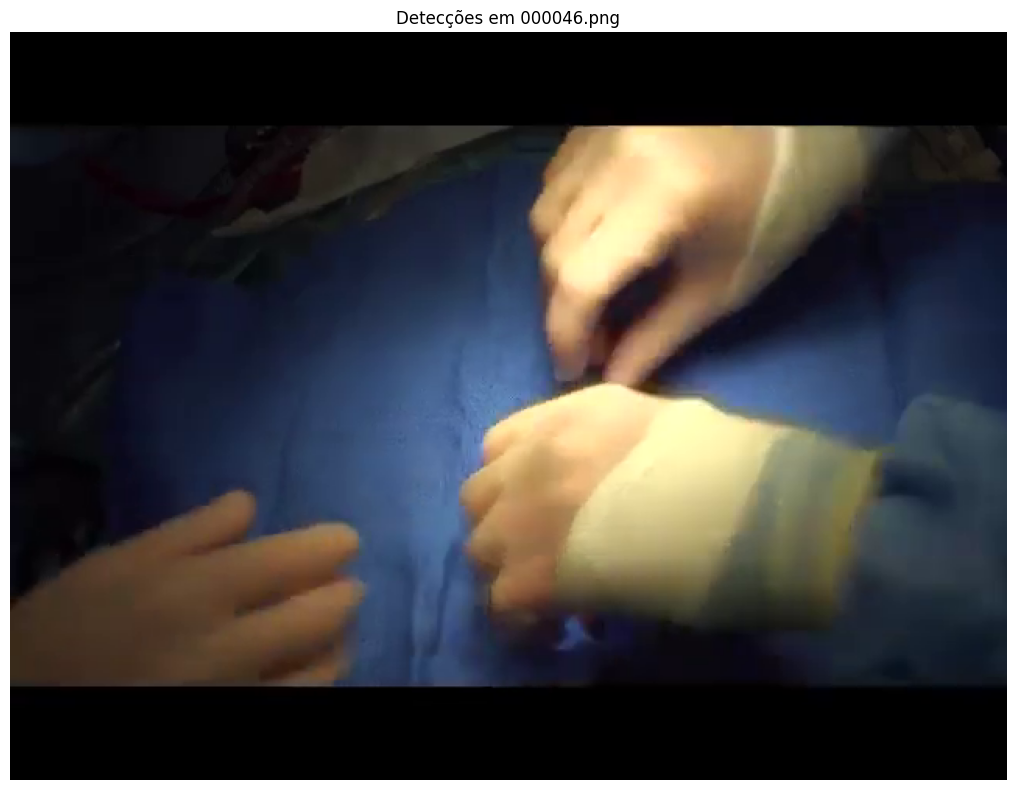

In [14]:
%matplotlib inline
import random
from pathlib import Path
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Configurar caminhos
photo_dir = Path("surgical_hands_release/images")

# Seleção aleatória em subpastas
subfolders = [f for f in photo_dir.iterdir() if f.is_dir()]
random_subfolder = random.choice(subfolders)
image_files = list(random_subfolder.glob("*.jpg")) + list(random_subfolder.glob("*.png"))
random_image_path = random.choice(image_files)

# Carregar modelo e imagem
model = YOLO("/mounts/grupo1/yolo_models/yoloTrackingWithSegmentation.pt")
frame = cv2.imread(str(random_image_path))

if frame is None:
    print("Erro ao carregar imagem")
else:
    # Fazer detecção
    results = model(frame)
    
    # Converter BGR para RGB e plotar
    result_img = results[0].plot()  # Já retorna imagem em BGR
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detecções em {random_image_path.name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [18]:
import numpy as np
from pathlib import Path
import cv2
import json
from collections import defaultdict

try:
    import torch
    from ultralytics import YOLO
    torch_available = True
except ImportError:
    torch_available = False

try:
    from PIL import Image
    pil_available = True
except ImportError:
    pil_available = False

class HOTAEvaluator:
    """Implementação da métrica HOTA para avaliação de segmentação"""
    
    def __init__(self, num_classes=6):
        self.num_classes = num_classes
        self.class_names = ['left_hand', 'right_hand', 'needle', 'clamp', 'curved_scissor', 'straight_scissor']
        self.reset()
    
    def reset(self):
        """Reset das métricas"""
        self.tp = defaultdict(int)  # True Positives
        self.fp = defaultdict(int)  # False Positives
        self.fn = defaultdict(int)  # False Negatives
        self.iou_sum = defaultdict(float)
        self.total_predictions = 0
        self.total_ground_truth = 0
    
    def polygon_to_mask(self, polygon, img_width, img_height):
        """Converte polígono para máscara binária"""
        if len(polygon) < 6:
            return np.zeros((img_height, img_width), dtype=np.uint8)
        
        # Converter coordenadas normalizadas para pixels
        points = []
        for i in range(0, len(polygon), 2):
            x = int(polygon[i] * img_width)
            y = int(polygon[i + 1] * img_height)
            points.append([x, y])
        
        points = np.array(points, dtype=np.int32)
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        cv2.fillPoly(mask, [points], 255)
        return mask
    
    def calculate_iou(self, mask1, mask2):
        """Calcula IoU entre duas máscaras"""
        intersection = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()
        
        if union == 0:
            return 0.0
        return intersection / union
    
    def match_predictions_to_ground_truth(self, predictions, ground_truth, img_width, img_height, iou_threshold=0.5):
        """Associa predições ao ground truth"""
        matches = []
        used_gt = set()
        
        # Ordenar predições por confiança
        predictions = sorted(predictions, key=lambda x: x.get('confidence', 1.0), reverse=True)
        
        for pred in predictions:
            pred_class = pred['class']
            pred_polygon = pred['polygon']
            pred_mask = self.polygon_to_mask(pred_polygon, img_width, img_height)
            
            best_iou = 0.0
            best_gt_idx = -1
            
            for gt_idx, gt in enumerate(ground_truth):
                if gt_idx in used_gt or gt['class'] != pred_class:
                    continue
                
                gt_polygon = gt['polygon']
                gt_mask = self.polygon_to_mask(gt_polygon, img_width, img_height)
                iou = self.calculate_iou(pred_mask, gt_mask)
                
                if iou > best_iou and iou >= iou_threshold:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            if best_gt_idx != -1:
                matches.append((pred_polygon, ground_truth[best_gt_idx]['polygon'], best_iou))
                used_gt.add(best_gt_idx)
                self.tp[pred_class] += 1
                self.iou_sum[pred_class] += best_iou
            else:
                self.fp[pred_class] += 1
        
        # Contar false negatives
        for gt_idx, gt in enumerate(ground_truth):
            if gt_idx not in used_gt:
                self.fn[gt['class']] += 1
        
        return matches
    
    def update(self, predictions, ground_truth, img_width, img_height):
        """Atualiza métricas com novas predições"""
        self.total_predictions += len(predictions)
        self.total_ground_truth += len(ground_truth)
        
        matches = self.match_predictions_to_ground_truth(
            predictions, ground_truth, img_width, img_height
        )
        
        return matches
    
    def calculate_hota(self):
        """Calcula HOTA final"""
        hota_scores = {}
        overall_metrics = {'DetA': 0.0, 'AssA': 0.0, 'HOTA': 0.0}
        
        total_tp = 0
        total_fp = 0
        total_fn = 0
        total_iou = 0.0
        
        for class_id in range(self.num_classes):
            tp = self.tp[class_id]
            fp = self.fp[class_id]
            fn = self.fn[class_id]
            
            total_tp += tp
            total_fp += fp
            total_fn += fn
            
            if tp > 0:
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
                det_a = self.iou_sum[class_id] / tp if tp > 0 else 0.0
                
                # HOTA = sqrt(DetA * AssA)
                ass_a = det_a  # Para segmentação, AssA ≈ DetA
                hota = np.sqrt(det_a * ass_a)
                
                total_iou += self.iou_sum[class_id]
                
                hota_scores[self.class_names[class_id]] = {
                    'HOTA': hota,
                    'DetA': det_a,
                    'AssA': ass_a,
                    'Precision': precision,
                    'Recall': recall,
                    'TP': tp,
                    'FP': fp,
                    'FN': fn
                }
            else:
                hota_scores[self.class_names[class_id]] = {
                    'HOTA': 0.0,
                    'DetA': 0.0,
                    'AssA': 0.0,
                    'Precision': 0.0,
                    'Recall': 0.0,
                    'TP': 0,
                    'FP': fp,
                    'FN': fn
                }
        
        # Métricas gerais
        if total_tp > 0:
            overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
            overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
            overall_det_a = total_iou / total_tp if total_tp > 0 else 0.0
            overall_ass_a = overall_det_a
            overall_hota = np.sqrt(overall_det_a * overall_ass_a)
            
            overall_metrics = {
                'HOTA': overall_hota,
                'DetA': overall_det_a,
                'AssA': overall_ass_a,
                'Precision': overall_precision,
                'Recall': overall_recall,
                'Total_TP': total_tp,
                'Total_FP': total_fp,
                'Total_FN': total_fn
            }
        
        return hota_scores, overall_metrics

class ModelTester:
    """Classe para testar modelo de segmentação já treinado"""
    
    def __init__(self, model_path):
        self.model_path = Path(model_path)
        if not self.model_path.exists():
            raise FileNotFoundError(f"Modelo não encontrado: {model_path}")
        
        if torch_available:
            print(f"Carregando modelo: {model_path}")
            self.model = YOLO(str(model_path))
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(f"Modelo carregado no dispositivo: {self.device}")
        else:
            raise ImportError("PyTorch não disponível")
    
    def load_ground_truth(self, label_file):
        """Carrega ground truth de arquivo de anotação"""
        ground_truth = []
        
        if not label_file.exists():
            return ground_truth
        
        try:
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 9:  # class + pelo menos 8 coordenadas
                    class_id = int(parts[0])
                    polygon = [float(x) for x in parts[1:]]
                    
                    ground_truth.append({
                        'class': class_id,
                        'polygon': polygon
                    })
        
        except Exception as e:
            print(f"Erro ao carregar ground truth {label_file}: {e}")
        
        return ground_truth
    
    def predict_image(self, image_path, conf_threshold=0.25):
        """Faz predição em uma imagem"""
        predictions = []
        
        try:
            results = self.model(str(image_path), conf=conf_threshold, verbose=False)
            
            for result in results:
                if hasattr(result, 'masks') and result.masks is not None:
                    # Segmentação disponível
                    masks = result.masks.xy  # Coordenadas dos polígonos
                    boxes = result.boxes
                    
                    for i, mask_coords in enumerate(masks):
                        if len(mask_coords) >= 3:  # Mínimo 3 pontos
                            class_id = int(boxes.cls[i])
                            confidence = float(boxes.conf[i])
                            
                            # Normalizar coordenadas
                            img_height, img_width = result.orig_shape
                            normalized_polygon = []
                            
                            for point in mask_coords:
                                x_norm = point[0] / img_width
                                y_norm = point[1] / img_height
                                normalized_polygon.extend([x_norm, y_norm])
                            
                            predictions.append({
                                'class': class_id,
                                'polygon': normalized_polygon,
                                'confidence': confidence
                            })
                
                elif hasattr(result, 'boxes') and result.boxes is not None:
                    # Apenas detecção - converter para polígono
                    boxes = result.boxes
                    img_height, img_width = result.orig_shape
                    
                    for i, box in enumerate(boxes.xyxy):
                        class_id = int(boxes.cls[i])
                        confidence = float(boxes.conf[i])
                        
                        # Converter bbox para polígono normalizado
                        x1, y1, x2, y2 = box.cpu().numpy()
                        polygon = [
                            x1/img_width, y1/img_height,
                            x2/img_width, y1/img_height,
                            x2/img_width, y2/img_height,
                            x1/img_width, y2/img_height
                        ]
                        
                        predictions.append({
                            'class': class_id,
                            'polygon': polygon,
                            'confidence': confidence
                        })
        
        except Exception as e:
            print(f"Erro na predição para {image_path}: {e}")
        
        return predictions
    
    def test_dataset(self, test_images_dir, test_labels_dir, output_dir=None):
        """Testa modelo em dataset e calcula HOTA"""
        test_images_path = Path(test_images_dir)
        test_labels_path = Path(test_labels_dir)
        
        if output_dir:
            output_path = Path(output_dir)
            output_path.mkdir(parents=True, exist_ok=True)
        
        evaluator = HOTAEvaluator()
        
        # Processar todas as imagens
        image_files = list(test_images_path.glob("*.jpg")) + list(test_images_path.glob("*.png"))
        
        print(f"Testando modelo em {len(image_files)} imagens...")
        
        results_data = []
        
        for i, img_file in enumerate(image_files):
            if i % 10 == 0:  # Progress update
                print(f"Processando {i+1}/{len(image_files)}: {img_file.name}")
            
            # Carregar ground truth
            label_file = test_labels_path / f"{img_file.stem}.txt"
            ground_truth = self.load_ground_truth(label_file)
            
            # Fazer predição
            predictions = self.predict_image(img_file)
            
            # Obter dimensões da imagem
            if pil_available:
                with Image.open(img_file) as pil_img:
                    img_width, img_height = pil_img.size
            else:
                img = cv2.imread(str(img_file))
                img_height, img_width = img.shape[:2]
            
            # Atualizar avaliador
            matches = evaluator.update(predictions, ground_truth, img_width, img_height)
            
            # Salvar resultados desta imagem
            results_data.append({
                'image': img_file.name,
                'predictions': len(predictions),
                'ground_truth': len(ground_truth),
                'matches': len(matches)
            })
            
            # Salvar visualização se solicitado
            if output_dir and i < 20:  # Salvar apenas primeiras 20 para não sobrecarregar
                self.save_visualization(img_file, predictions, ground_truth, 
                                      output_path / f"result_{img_file.stem}.jpg")
        
        # Calcular HOTA final
        class_scores, overall_metrics = evaluator.calculate_hota()
        
        # Salvar relatório
        if output_dir:
            self.save_report(class_scores, overall_metrics, results_data, output_path)
        
        return class_scores, overall_metrics, results_data
    
    def save_visualization(self, img_path, predictions, ground_truth, output_path):
        """Salva visualização com predições e ground truth"""
        try:
            img = cv2.imread(str(img_path))
            img_height, img_width = img.shape[:2]
            
            # Desenhar ground truth em verde
            for gt in ground_truth:
                polygon = gt['polygon']
                points = []
                for i in range(0, len(polygon), 2):
                    x = int(polygon[i] * img_width)
                    y = int(polygon[i + 1] * img_height)
                    points.append([x, y])
                
                if len(points) >= 3:
                    points = np.array(points, dtype=np.int32)
                    cv2.polylines(img, [points], True, (0, 255, 0), 2)
                    cv2.putText(img, f"GT:{gt['class']}", tuple(points[0]), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            # Desenhar predições em vermelho
            for pred in predictions:
                polygon = pred['polygon']
                points = []
                for i in range(0, len(polygon), 2):
                    x = int(polygon[i] * img_width)
                    y = int(polygon[i + 1] * img_height)
                    points.append([x, y])
                
                if len(points) >= 3:
                    points = np.array(points, dtype=np.int32)
                    cv2.polylines(img, [points], True, (0, 0, 255), 2)
                    conf = pred.get('confidence', 0.5)
                    cv2.putText(img, f"P:{pred['class']}({conf:.2f})", tuple(points[0]), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            
            cv2.imwrite(str(output_path), img)
        
        except Exception as e:
            print(f"Erro ao salvar visualização: {e}")
    
    def save_report(self, class_scores, overall_metrics, results_data, output_dir):
        """Salva relatório detalhado"""
        report_path = output_dir / "hota_evaluation_report.txt"
        
        with open(report_path, 'w') as f:
            f.write("=== RELATÓRIO DE AVALIAÇÃO HOTA ===\n\n")
            
            f.write("MÉTRICAS GERAIS:\n")
            for metric, value in overall_metrics.items():
                if isinstance(value, float):
                    f.write(f"{metric}: {value:.4f}\n")
                else:
                    f.write(f"{metric}: {value}\n")
            f.write("\n")
            
            f.write("MÉTRICAS POR CLASSE:\n")
            for class_name, metrics in class_scores.items():
                f.write(f"\n{class_name.upper()}:\n")
                for metric, value in metrics.items():
                    if isinstance(value, float):
                        f.write(f"  {metric}: {value:.4f}\n")
                    else:
                        f.write(f"  {metric}: {value}\n")
            
            f.write(f"\n\nTOTAL DE IMAGENS TESTADAS: {len(results_data)}\n")
            f.write("RESUMO POR IMAGEM (primeiras 50):\n")
            for i, result in enumerate(results_data[:50]):
                f.write(f"{result['image']}: {result['predictions']} pred, "
                       f"{result['ground_truth']} gt, {result['matches']} matches\n")
        
        print(f"Relatório salvo em: {report_path}")

def evaluate_trained_model():
    """Função principal para avaliar modelo já treinado"""
    
    model_path = "/mounts/grupo1/yolo_models/yoloTrackingWithSegmentation.pt" 
    test_images_dir = "combined_surgical_dataset/images/train"  
    test_labels_dir = "combined_surgical_dataset/labels/train"
    output_dir = "evaluation_results"
    
    print("=== AVALIAÇÃO DO MODELO TREINADO ===\n")
    
    # Verificar se modelo existe
    if not Path(model_path).exists():
        print(f"❌ Modelo não encontrado: {model_path}")
        print("Verifique o caminho do modelo!")
        return None, None
    
    # Verificar se dataset de teste existe
    if not Path(test_images_dir).exists():
        print(f"❌ Dataset de teste não encontrado: {test_images_dir}")
        print("Verifique o caminho do dataset!")
        return None, None
    
    try:
        # Criar testador
        tester = ModelTester(model_path)
        
        # Executar avaliação
        print("Iniciando avaliação HOTA...")
        class_scores, overall_metrics, results_data = tester.test_dataset(
            test_images_dir, test_labels_dir, output_dir
        )
        
        # Mostrar resultados
        print("\n" + "="*60)
        print("RESULTADOS DA AVALIAÇÃO HOTA")
        print("="*60)
        
        print(f"\nMÉTRICAS GERAIS:")
        print(f"   HOTA: {overall_metrics['HOTA']:.4f}")
        print(f"   DetA: {overall_metrics['DetA']:.4f}")
        print(f"   AssA: {overall_metrics['AssA']:.4f}")
        print(f"   Precisão: {overall_metrics['Precision']:.4f}")
        print(f"   Recall: {overall_metrics['Recall']:.4f}")
        
        
        print(f"📈 Total de imagens testadas: {len(results_data)}")
        
        return class_scores, overall_metrics
        
    except Exception as e:
        print(f"❌ Erro durante a avaliação: {e}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    evaluate_trained_model()


=== AVALIAÇÃO DO MODELO TREINADO ===

Carregando modelo: /mounts/grupo1/yolo_models/yoloTrackingWithSegmentation.pt
Modelo carregado no dispositivo: cuda
Iniciando avaliação HOTA...
Testando modelo em 3009 imagens...
Processando 1/3009: tesouracurva28.jpg
Processando 11/3009: bisturi216.jpg
Processando 21/3009: pinca321.jpg
Processando 31/3009: pinca313.jpg
Processando 41/3009: pinca641.jpg
Processando 51/3009: tesouracurva214.jpg
Processando 61/3009: tesouracurva246.jpg
Processando 71/3009: pinca409.jpg
Processando 81/3009: tesourareta573.jpg
Processando 91/3009: pinca530.jpg
Processando 101/3009: tesouracurva662.jpg
Processando 111/3009: bisturi148.jpg
Processando 121/3009: bisturi496.jpg
Processando 131/3009: tesouracurva773.jpg
Processando 141/3009: bisturi262.jpg
Processando 151/3009: tesourareta65.jpg
Processando 161/3009: pinca609.jpg
Processando 171/3009: pinca141.jpg
Processando 181/3009: pinca673.jpg
Processando 191/3009: tesouracurva126.jpg
Processando 201/3009: tesouracurva